In [22]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [ ]:
M = 1.0 # Mass of the cart (kg)
m = 0.1 # Mass of the pendulum (kg)
l = 0.5 # Length to the pendulum's center of mass (m)
g = 9.81 # Acceleration due to gravity (m/s^2)

def inverted_pendulum_dynamics(state, t, F):
    """
    Defines the non-linear dynamics of the inverted pendulum on a cart.
    State vector: [x, x_dot, theta, theta_dot].
    """
    x, x_dot, theta, theta_dot = state
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    D = M + m * sin_theta**2
    x_ddot = (F + m * l * theta_dot**2 * sin_theta - m * g * sin_theta * cos_theta) / D
    theta_ddot = (g * (M + m) * sin_theta - F * cos_theta - m * l * theta_dot**2 * sin_theta * cos_theta) / (l * D)
    
    return [x_dot, x_ddot, theta_dot, theta_ddot]

--- Part 2: Simulating Manually Tuned PID Controller ---


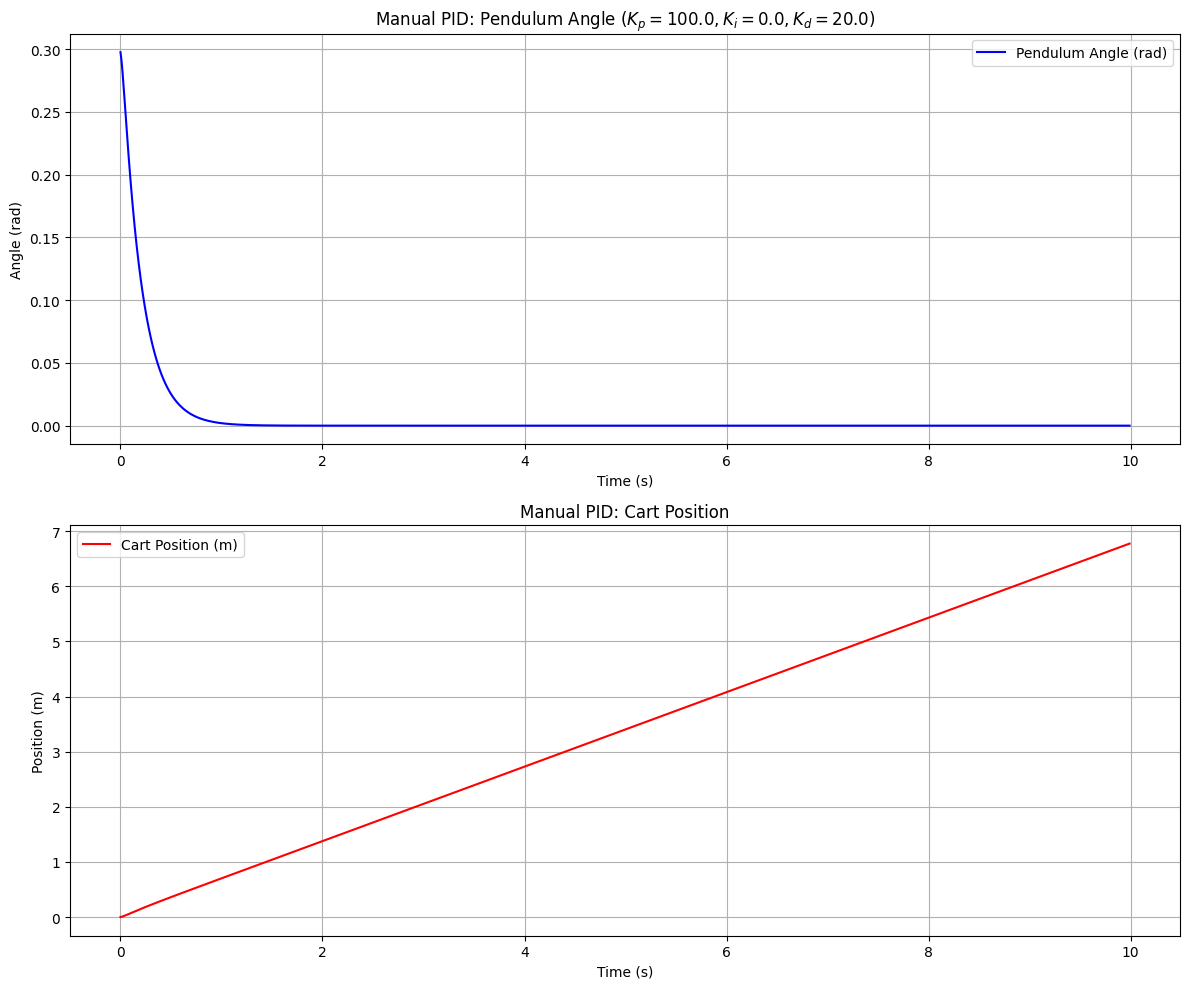

--- Classical Control Results ---
Final pendulum angle: 0.0000 rad
Final cart position: 6.77 m



In [ ]:
# --- 2. Classical Control (Manually Tuned PID) ---
class PIDController:
    def __init__(self, Kp, Ki, Kd, i_limit=5.0, u_limit=100.0):
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.integral = 0.0
        self.i_limit, self.u_limit = i_limit, u_limit

    def calculate_force(self, error, d_error):
        self.integral = np.clip(self.integral + error, -self.i_limit, self.i_limit)
        u = self.Kp*error + self.Ki*self.integral + self.Kd*d_error
        return float(np.clip(u, -self.u_limit, self.u_limit))

print("--- Part 2: Simulating Manually Tuned PID Controller ---")
initial_state = [0.0, 0.0, 0.3, 0.0]  # Benchmark scenario: larger initial angle
t_end = 10.0
dt = 0.01
t_span = np.arange(0, t_end, dt)

# Manually tuned gains
Kp_manual = 100.0
Ki_manual = 0.0
Kd_manual = 20.0
pid_manual = PIDController(Kp=Kp_manual, Ki=Ki_manual, Kd=Kd_manual)

state = initial_state
solution_manual = []
for t in t_span:
    error, d_error = state[2], state[3]
    F_applied = pid_manual.calculate_force(error, d_error)
    state_next = odeint(inverted_pendulum_dynamics, state, [t, t + dt], args=(F_applied,))
    state = state_next[-1]
    solution_manual.append(state)

solution_manual = np.array(solution_manual)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(t_span, solution_manual[:, 2], label='Pendulum Angle (rad)', color='blue')
ax1.set_title(f'Manual PID: Pendulum Angle ($K_p={Kp_manual}, K_i={Ki_manual}, K_d={Kd_manual}$)')
ax1.set_xlabel('Time (s)'); ax1.set_ylabel('Angle (rad)'); ax1.grid(True); ax1.legend()

ax2.plot(t_span, solution_manual[:, 0], label='Cart Position (m)', color='red')
ax2.set_title('Manual PID: Cart Position')
ax2.set_xlabel('Time (s)'); ax2.set_ylabel('Position (m)'); ax2.grid(True); ax2.legend()
plt.tight_layout(); plt.show()

print("--- Classical Control Results ---")
print(f"Final pendulum angle: {solution_manual[-1, 2]:.4f} rad")
print(f"Final cart position: {solution_manual[-1, 0]:.2f} m\n")

--- Part 3: Conceptual RL Training for PID Gains ---
Episode 20/200: Avg Reward = -114.70
Episode 40/200: Avg Reward = -113.60
Episode 60/200: Avg Reward = -112.09
Episode 80/200: Avg Reward = -109.01
Episode 100/200: Avg Reward = -110.16
Episode 120/200: Avg Reward = -111.10
Episode 140/200: Avg Reward = -115.74
Episode 160/200: Avg Reward = -114.04
Episode 180/200: Avg Reward = -114.64
Episode 200/200: Avg Reward = -111.57


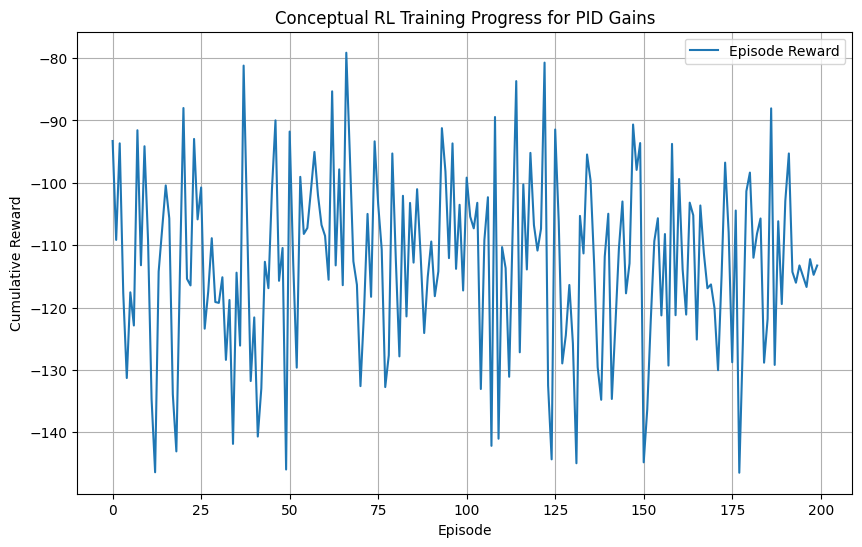

In [ ]:
# --- 3. Conceptual Machine Learning for PID Tuning ---
class InvertedPendulumEnv:
    def __init__(self, M=1.0, m=0.1, l=0.5, g=9.81, dt=0.01, x_limit=2.5, F_limit=50.0):
        self.M, self.m, self.l, self.g = M, m, l, g
        self.dt, self.x_limit, self.F_limit = dt, x_limit, F_limit
        self.state = None

    def step(self, force):
        force = float(np.clip(force, -self.F_limit, self.F_limit))
        self.state = odeint(self._dynamics, self.state, [0, self.dt], args=(force,))[-1]
        x, x_dot, theta, theta_dot = self.state

        cost = (10*theta**2 + 5*x**2 + 0.1*theta_dot**2 + 0.01*x_dot**2 + 0.001*force**2)
        reward = -cost * self.dt # horizon-invariant

        runaway = (abs(theta) > np.pi/2) or (abs(x) > self.x_limit)
        done = bool(runaway)
        if done:
            reward -= 50.0 # small terminal penalty
        return self.state, reward, done

    def reset(self):
        self.state = np.random.uniform(low=[-0.2,-0.2,-0.2,-0.2], high=[0.2,0.2,0.2,0.2])
        return self.state

    def _dynamics(self, state, t, F):
        x, x_dot, theta, theta_dot = state
        sin_theta, cos_theta = np.sin(theta), np.cos(theta)
        D = self.M + self.m * sin_theta**2
        x_ddot = (F + self.m * self.l * theta_dot**2 * sin_theta - self.m * self.g * sin_theta * cos_theta) / D
        theta_ddot = (self.g * (self.M + self.m) * sin_theta - F * cos_theta - self.m * self.l * theta_dot**2 * sin_theta * cos_theta) / (self.l * D)
        return [x_dot, x_ddot, theta_dot, theta_ddot]

class PPOTuningAgent:
    def __init__(self, bounds=( (1e-2, 300.0), (0.0, 20.0), (0.0, 100.0) )):
        self.gains = np.random.uniform([0.5, 0.0, 0.5], [50.0, 5.0, 20.0])
        self.bounds = bounds
        self.baseline = None

    def update_gains(self, avg_reward, step_scale=0.2):
        if self.baseline is None: self.baseline = avg_reward
        advantage = avg_reward - self.baseline
        self.baseline = 0.9*self.baseline + 0.1*avg_reward

        noise = np.random.normal(size=3)
        step = step_scale * (1.0 / (1.0 + np.exp(-advantage/1000.0))) * noise
        self.gains = np.clip(self.gains * (1.0 + 0.05*step), 
                             [b[0] for b in self.bounds], 
                             [b[1] for b in self.bounds])

print("--- Part 3: Conceptual RL Training for PID Gains ---")
env = InvertedPendulumEnv()
agent = PPOTuningAgent()
num_episodes = 200
max_steps = 2000
K = 10 # rollouts per update
training_rewards = []

for episode in range(num_episodes):
    pid = PIDController(*agent.gains)
    ep_rewards = []
    for _ in range(K):
        state = env.reset()
        episode_reward = 0.0
        for _ in range(max_steps):
            error, d_error = state[2], state[3]
            force = pid.calculate_force(error, d_error)
            state, reward, done = env.step(force)
            episode_reward += reward
            if done: break
        ep_rewards.append(episode_reward)

    avg_r = float(np.mean(ep_rewards))
    training_rewards.append(avg_r)
    agent.update_gains(avg_r)

    if (episode + 1) % 20 == 0:
        print(f"Episode {episode+1}/{num_episodes}: Avg Reward = {np.mean(training_rewards[-20:]):.2f}")

plt.figure(figsize=(10, 6))
plt.plot(training_rewards, label='Episode Reward')
plt.title('Conceptual RL Training Progress for PID Gains')
plt.xlabel('Episode'); plt.ylabel('Cumulative Reward'); plt.grid(True); plt.legend()
plt.show()


--- Part 4: Final Simulation with ML-Tuned Gains ---


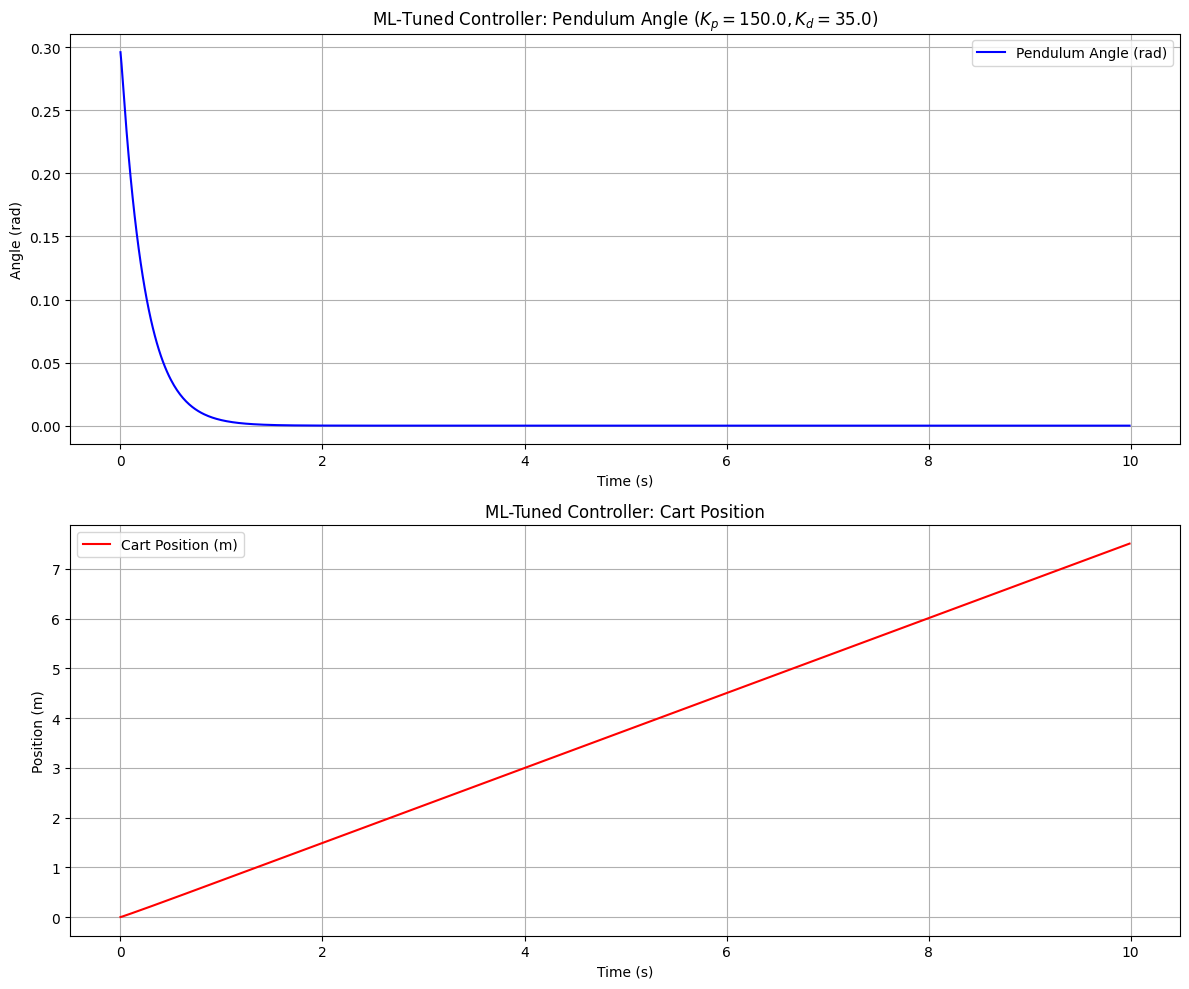


--- ML-Tuned Controller Results ---
Final pendulum angle: -0.0000 rad
Final cart position: 7.51 m


In [ ]:
# --- 4. Final Simulation with ML-Tuned Gains ---
print("\n--- Part 4: Final Simulation with ML-Tuned Gains ---")
learned_Kp = 150.0  # Assumed learned
learned_Ki = 0.0    # Assumed learned
learned_Kd = 35.0   # Assumed learned

pid_ml = PIDController(learned_Kp, learned_Ki, learned_Kd)
state = initial_state
solution_ml = []
for t in t_span:
    error, d_error = state[2], state[3]
    force = pid_ml.calculate_force(error, d_error)
    state_next = odeint(inverted_pendulum_dynamics, state, [t, t + dt], args=(force,))
    state = state_next[-1]
    solution_ml.append(state)
solution_ml = np.array(solution_ml)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(t_span, solution_ml[:, 2], label='Pendulum Angle (rad)', color='blue')
ax1.set_title(f'ML-Tuned Controller: Pendulum Angle ($K_p={learned_Kp}, K_d={learned_Kd}$)')
ax1.set_xlabel('Time (s)'); ax1.set_ylabel('Angle (rad)'); ax1.grid(True); ax1.legend()
ax2.plot(t_span, solution_ml[:, 0], label='Cart Position (m)', color='red')
ax2.set_title('ML-Tuned Controller: Cart Position')
ax2.set_xlabel('Time (s)'); ax2.set_ylabel('Position (m)'); ax2.grid(True); ax2.legend()
plt.tight_layout(); plt.show()

print("\n--- ML-Tuned Controller Results ---")
print(f"Final pendulum angle: {solution_ml[-1, 2]:.4f} rad")
print(f"Final cart position: {solution_ml[-1, 0]:.2f} m")